# Assignment 5: Epipolar geometry and triangulation

In [101]:
#imports
import numpy as np
from matplotlib import pyplot as plt
from a5_utils import *
import cv2 as cv2
from UZ_utils import *
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150 

## Exercise 1: Disparity

In this assignment we will focus on calculating disparity from a two-camera system. Our
analysis will be based on a simplified stereo system, where two identical cameras are
aligned with parallel optical axes and their image planes (CCD sensors) lie on the same
plane (Image 1a).

a) the further the object is the lower the disparity

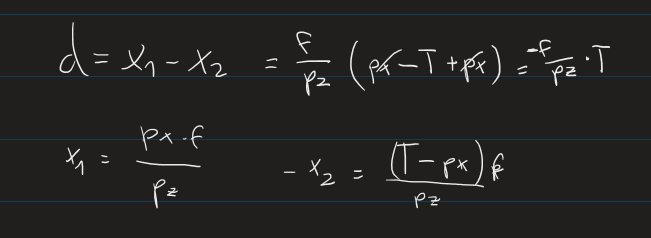

### B)
Write a script that computes the disparity for a range of values of pz. Plot the values
to a figure and set the appropriate units to axes. Use the following parameters of
the system: focal length is f = 2:5mm and stereo system baseline is T = 12cm.

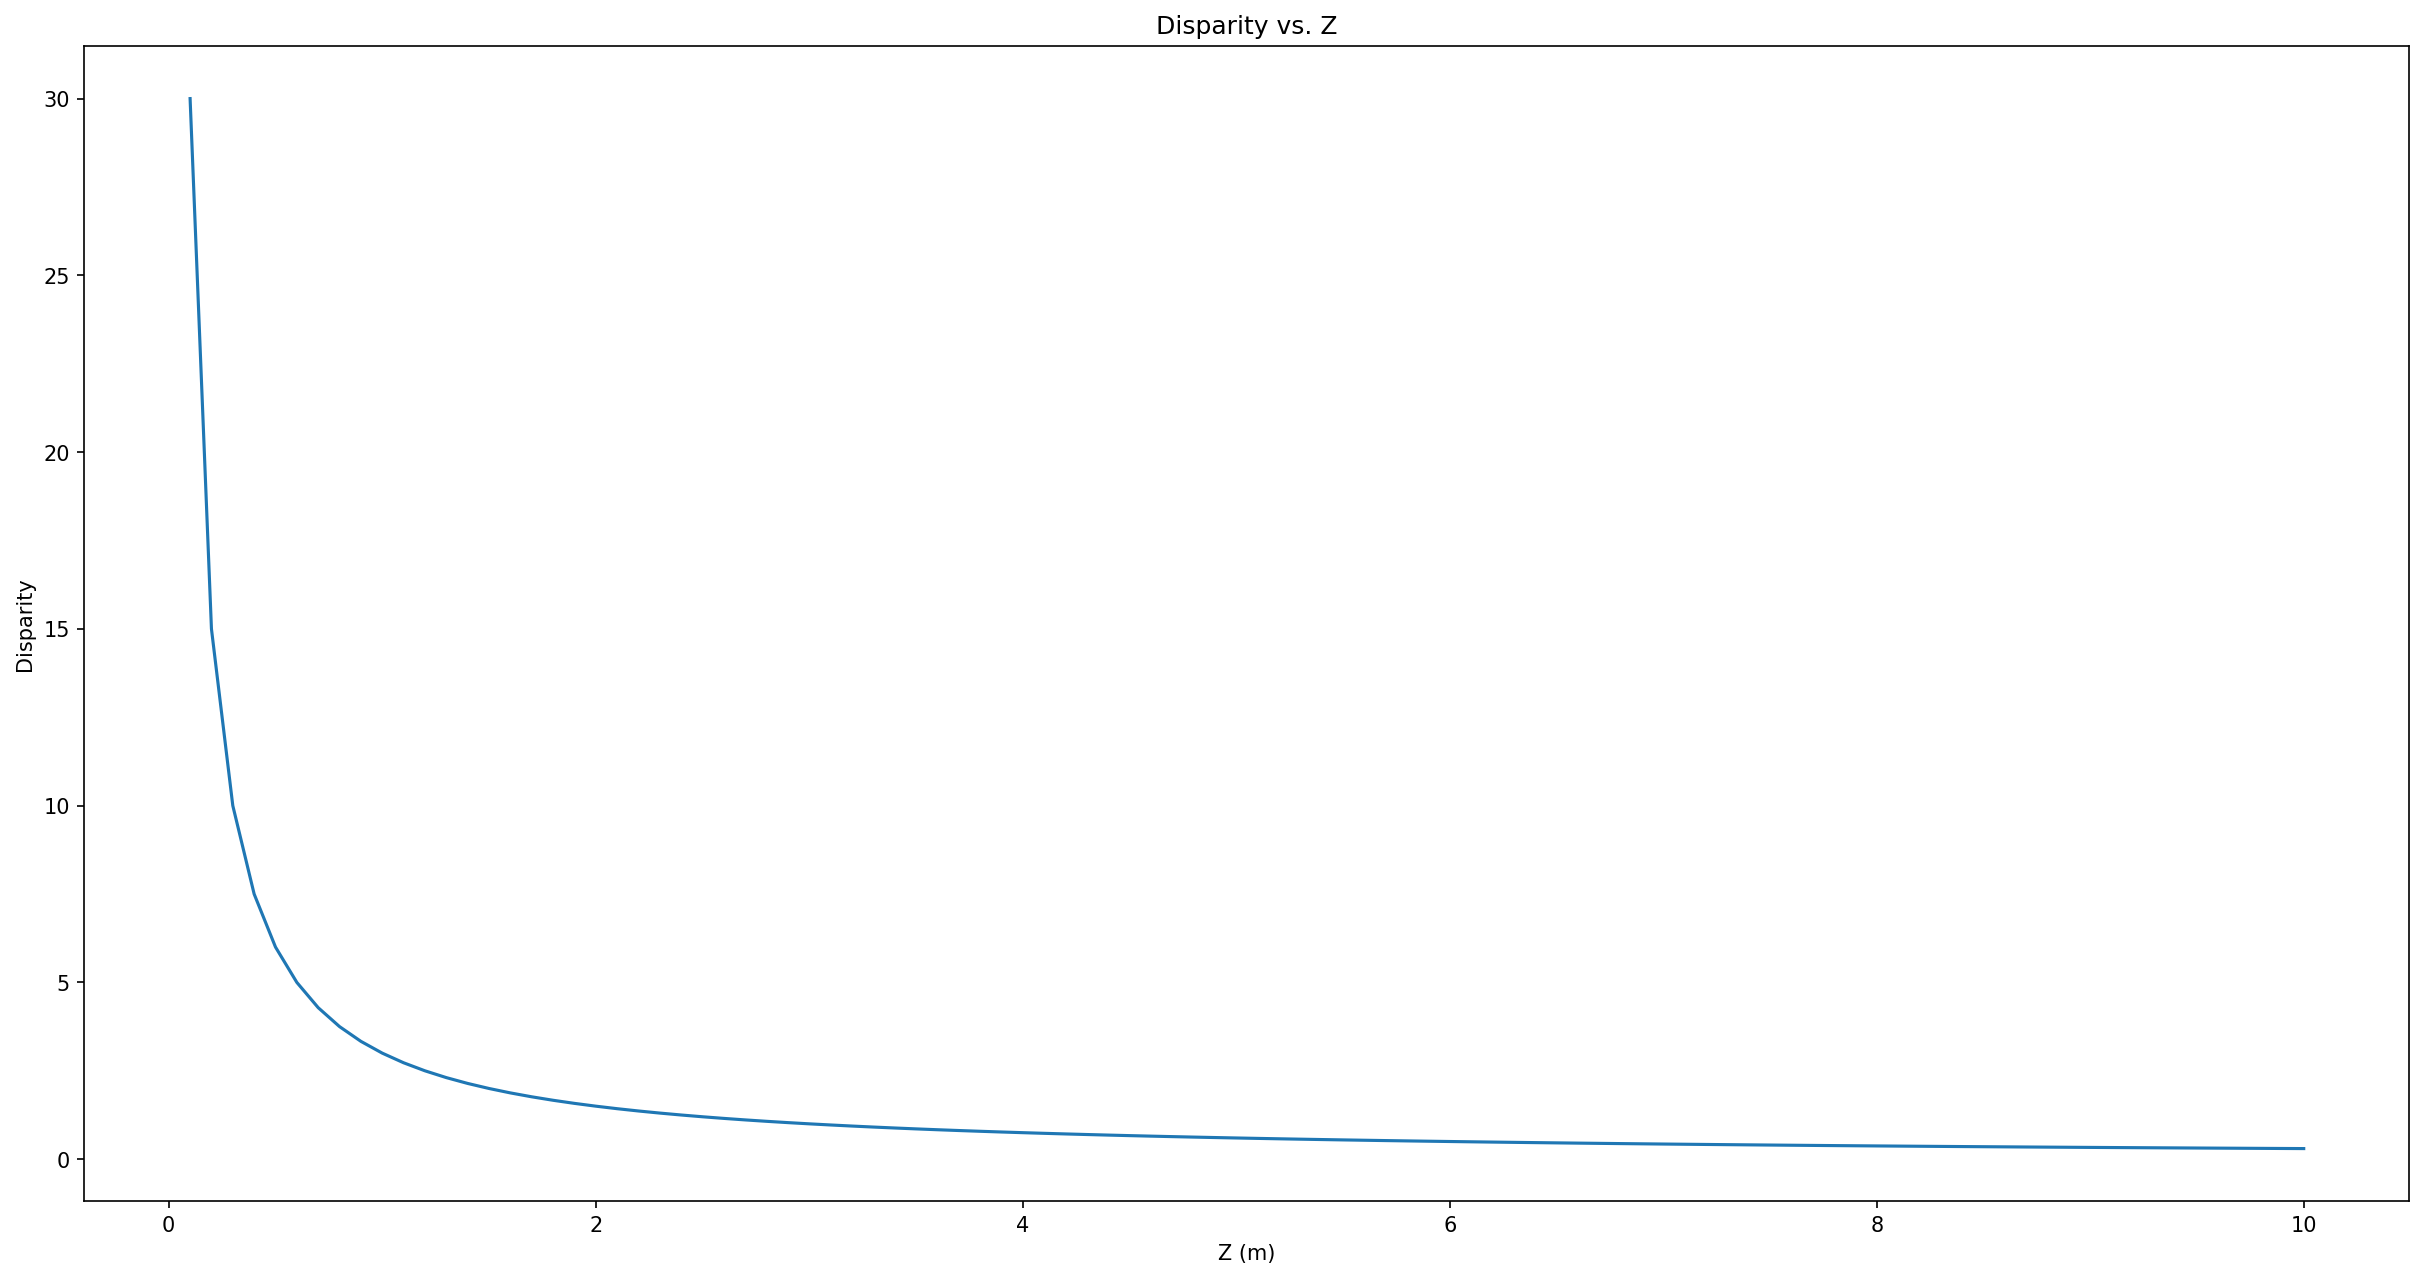

In [102]:

def disparity(pz, FOCAL_LENGTH=0.25, BASELINE=12):
  return BASELINE * FOCAL_LENGTH / pz


pz_s = np.linspace(0.1, 10, 100)
d_s = disparity(pz_s)

plt.plot(pz_s, d_s)
plt.xlabel('Z (m)')
plt.ylabel('Disparity')
plt.title('Disparity vs. Z')
plt.show()


### C)
In order to get a better grasp on the idea of distance and disparity, you will calculate
the numbers for a specific case. We will take the parameters from a specification of
a commercial stereo camera Bumblebee2 manufactured by the company PointGray:
f = 2.5mm, T = 12cm, whose image sensor has a resolution of 648x488 pixels that
are square and the width of a pixel is 7.4um. We assume that there is no empty
space between pixels and that both cameras are completely parallel and equal. Lets
say that we use this system to observe a (point) object that is detected at pixel 550
in x axis in the left camera and at the pixel 300 in the right camera. How far is the
object (in meters) in this case? How far is the object if the object is detected at
pixel 540 in the right camera? Solve this task analytically and bring your solution
to the presentation of the exercise.

In [103]:
focal = 0.25
t = 12
height =  488
width =  648
pixel_size = 7.5e-6


# 540 in infinity and beyond
# couple of cm


### D)
Write a script that calculates the disparity for an image pair. Use
the images in the directory disparity. Since the images were pre-processed we can
limit the search for the most similar pixel to the same row in the other image. Since
just the image intensity carries too little information, we will instead compare small
image patches. A simple way of finding a matching patch is to use normalized cross
correlation.
A patch
from the second image is considered a match if it has the highest NCC value. The
difference in x axis between the point from the first image and the matching point
from the second image is the disparity estimate in terms of pixels1. The disparity
search is performed in a single direction.

In [104]:
def normalized_cross_correlation(img1, img2):
  mean1 = np.mean(img1)
  mean2 = np.mean(img2)
  top = np.sum((img1 - mean1) * (img2 - mean2))
  bottom = np.sqrt(np.sum((img1 - mean1)**2) * np.sum((img2 - mean2)**2))
  return top / bottom

def disparity_map(img1, img2, window_size=35):
  height, width = img1.shape
  disparity_map = np.zeros((height, width))
  for i in range(height):
    for j in range(width):
      top = max(i - window_size // 2, 0)
      bottom = min(i + window_size // 2, height)
      left = max(j - window_size // 2, 0)
      right = min(j + window_size // 2, width)
      window1 = img1[top:bottom, left:right]
      window2 = img2[top:bottom, left:right]
      disparity_map[i, j] = normalized_cross_correlation(window1, window2)
  return disparity_map

image1 = cv2.imread('./data/disparity/office_left.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./data/disparity/office_right.png', cv2.IMREAD_GRAYSCALE)

disparity_map = disparity_map(image1, image2)
plt.imshow(disparity_map, cmap='gray')
plt.show()


C:\Users\Blaz\AppData\Local\Temp\ipykernel_29828\782319119.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return top / bottom


## Exercise 2: Fundamental matrix, epipoles, epipolar lines

### A)
na listu


### B)
Implement a function fundamental_matrix that is given a set of (at least) eight
pairs of points from two images and computes the fundamental matrix using the
eight-point algorithm.
As the eight-point algorithm can be numerically unstable, it is usually not executed
directly on given pairs of points. Instead, the input is first normalized by centering
them to their centroid and scaling their positions so that the average distance to the
centroid sqrt(2). To achieve this, you can use the function normalize_points from
the supplementary material.

In [ ]:
def fundamental_matrix(p1, p2):
  # normalize points
  p1, T1 = normalize_points(p1)
  p2, T2 = normalize_points(p2)
  #generate A matrix
  A = np.zeros((p1.shape[0], 9))
  for i in range(p1.shape[0]):
    u1 = p1[i, 0]
    v1 = p1[i, 1]
    u2 = p2[i, 0]
    v2 = p2[i, 1]
    A[i] = np.array([u1 * u2, u2 * v1, u2, v2 * u1, v1 * v2, v2, u1, v1, 1])

  # decompose A into U, D, V
  U, D, V = np.linalg.svd(A)
  # F is the last column of V
  F = V[-1,:].reshape(3, 3)

  # decoimpose F into U, D, V
  U, D, V = np.linalg.svd(F)
  # set smallest singular value to 0
  D[-1] = 0
  # recompose F
  F = U @ np.diag(D) @ V
  # denormalize F
  F = T2.T @ F @ T1
  return F


house_1 = cv2.imread('./data/epipolar/house1.jpg', cv2.IMREAD_GRAYSCALE)
house_2 = cv2.imread('./data/epipolar/house2.jpg', cv2.IMREAD_GRAYSCALE)


points = np.loadtxt("./data/epipolar/house_points.txt")
points_1 = points[:, :2]
points_2 = points[:, 2:]

F = fundamental_matrix(points_1, points_2)
print(F)


#draw epipolar lines
def draw_epipolar_lines(img1, img2, points1, points2, F):
  # draw points
  plt.subplot(1, 2, 1)
  plt.imshow(img1, cmap='gray')
  plt.scatter(points1[:, 0], points1[:, 1], c='r' )
  plt.subplot(1, 2, 2)
  plt.imshow(img2, cmap='gray')
  plt.scatter(points2[:, 0], points2[:, 1], c='r')
  # draw epipolar lines
  for i in range(points1.shape[0]):
    p1 = points1[i]
    p2 = points2[i]
    l = F @ np.array([p1[0], p1[1], 1])
    x = np.linspace(0, img2.shape[1], 100)
    y = -(l[0] * x + l[2]) / l[1]
    plt.subplot(1, 2, 2)
    plt.plot(x, y, c='r')

    l_ = F.T @ np.array([p2[0], p2[1], 1])
    x_ = np.linspace(0, img1.shape[1], 100)
    y_ = -(l_[0] * x_ + l_[2]) / l_[1]
    plt.subplot(1, 2, 1)
    plt.plot(x_, y_, c='r')

  plt.show()



draw_epipolar_lines(house_1, house_2, points_1, points_2, F)




[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


<IPython.core.display.Javascript object>

### C)
We use the reprojection error as a quantitative measure of the quality of the estimated
fundamental matrix.
Write a function reprojection_error that calculates the reprojection error of a
fundamental matrix F given two matching points. For each point, the function
should calculate the corresponding epipolar line from the point’s match in the other
image, then calculate the perpendicular distance between the point and the line
using the equation:

In [ ]:
def reprojection_error(F, point1, point2):
  # convert to homogeneous coordinates
  p1 = np.array([point1[0], point1[1], 1])
  p2 = np.array([point2[0], point2[1], 1])
  # compute epipolar line
  l = F @ p1
  # compute distance between point and line
  left_to_right = np.abs(l @ p2) / np.sqrt(l[0]**2 + l[1]**2)

  l_ = F.T @ p2
  right_to_left = np.abs(l_ @ p1) / np.sqrt(l_[0]**2 + l_[1]**2)
  return (left_to_right + right_to_left)/2

test_error = reprojection_error(F, [85,233], [67,219])
print(test_error)

sum_error = 0
for i in range(points_1.shape[0]):
  sum_error += reprojection_error(F, points_1[i], points_2[i])

print(sum_error / points_1.shape[0])



0.14674365570456036
0.3309133698054238


## Exercise 3: Triangulation

### A)
Implement the function triangulate that accepts a set of correspondence points
and a pair of calibration matrices as an input and returns the triangulated 3D
points. Test the triangulation on the ten points from the file house_points.txt.
Visualize the result using plt.plot or plt.scatter. Also plot the index of the
point in 3D space (use plt.text) so the results will be easier to interpret. Plot the
points interactively, so that you can rotate the visualization.
Note: The coordinate system used for plotting in 3D space is usually not the same
as the camera coordinate system. In order to make the results easier to interpret, the
ordering of the axes can be modified by using a transformation matrix.

(10, 3)
[[-0.44205153  1.54030217 -5.01230428]
 [-1.97068355  1.92477674 -6.05018481]
 [ 0.97511147  0.75007785 -4.53202466]
 [-1.98645583  1.41500019 -6.22002494]
 [ 0.68410796 -0.04366522 -4.24452083]
 [-2.13525695  0.67963973 -5.98431514]
 [ 1.26554483 -1.12867185 -4.27048932]
 [-2.29040454 -0.17373835 -6.37481741]
 [-1.61590526  0.131136   -7.62304399]
 [-2.1647483   0.44985223 -6.16929652]]


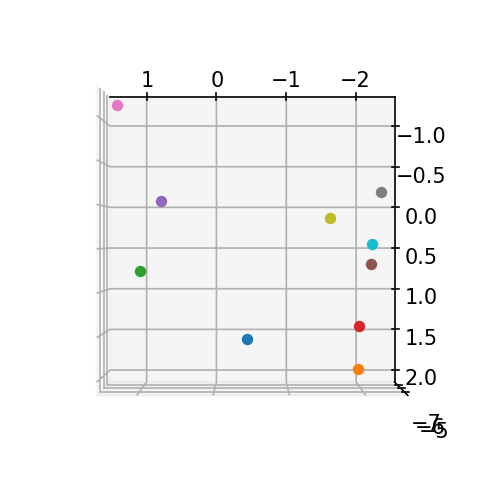

In [100]:
def triangulate(points1, points2, cal_mtx1, cal_mtx2):
  T = np.array([[-1, 0, 0],
                [0, 0, 1],
                [0, -1, 0]])
  # convert points to homogeneous coordinates
  points1 = np.array([points1[0], points1[1], 1])
  points2 = np.array([points2[0], points2[1], 1])

  points_1 = T @ points1
  points_2 =  T @ points2

  # points to matrix
  a= points1
  points1 = np.array([[0, -1, a[1]],
                      [1, 0, -a[0]],
                      [-a[1], a[0], 0]]) 
  b = points2
  points2 = np.array([[0, -1, b[1]],
                      [1, 0, -b[0]],
                      [-b[1], b[0], 0]])
  A1 =points1 @ cal_mtx1
  A2 = points2 @ cal_mtx2
  A = np.vstack((A1, A2))
  
  # decompose A into U, D, V
  U, D, V = np.linalg.svd(A)
  # X is the last column of V
  X = V[-1,:]
  X = X / X[-1]
  return X[:3]

#callibration matrix
camera1 = np.loadtxt("./data/epipolar/house1_camera.txt")
camera2 = np.loadtxt("./data/epipolar/house2_camera.txt")

# house points
points = np.loadtxt("./data/epipolar/house_points.txt")
points_1 = points[:, :2]
points_2 = points[:, 2:]
%matplotlib inline


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

# triangulate points
X = []
for i in range(points_1.shape[0]):
  X.append(triangulate(points_1[i], points_2[i], camera1, camera2))
  point = X[i]
  ax.scatter(point[0], point[1], point[2])



X = np.array(X)
print(X.shape)
print(X)


# plt.scatter(X[:,0],X[:,1],X[:,2])
# plt.show()




# ax.scatter(2,3,4) # plot the point (2,3,4) on the figure
ax.view_init(azim=90, elev=90, )
plt.show()
